# You are bot!
## Kaggle competition [(competition page)](https://www.kaggle.com/competitions/you-are-bot/overview)
This notebook is my solution to You are bot! kaggle competition that scored first on leaderboard.
The objective of the competition is to perform a binary classification to detect bots in dialogs.

In [2]:
import json
import math
from collections import Counter
from typing import List

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from catboost import CatBoostClassifier
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

sns.set_theme(style="darkgrid")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Raw data

## Loading and preprocessing

In [4]:
with open("../data/train.json") as train_json, open("../data/test.json") as test_json:
    train_data = json.load(train_json)
    test_data = json.load(test_json)
data = {"train": train_data, "test": test_data}

In [5]:
flattened_data = {"train": [], "test": []}
for split in ["train", "test"]:
    for conv_id, messages in data[split].items():
        for msg in messages:
            flattened_data[split].append(
                {
                    "id": conv_id,
                    "message": msg["message"],
                    "text": msg["text"],
                    "participant_index": msg["participant_index"],
                }
            )
train_df = pd.DataFrame(flattened_data["train"])
test_df = pd.DataFrame(flattened_data["test"])

In [6]:
train_df["ID"] = train_df["id"] + "_" + train_df["participant_index"]
test_df["ID"] = test_df["id"] + "_" + test_df["participant_index"]

In [7]:
train_df.shape, test_df.shape

((6334, 5), (2955, 5))

In [8]:
y_train = pd.read_csv("../data/ytrain.csv")
y_train["ID"] = y_train["dialog_id"] + "_" + y_train["participant_index"].astype(str)
y_train.drop(columns=["participant_index", "dialog_id"], inplace=True)

In [9]:
train_df = pd.merge(train_df, y_train, on="ID", how="left")

In [10]:
train_df = (
    train_df.groupby("id")
    .apply(lambda x: x.sort_values("message"))
    .reset_index(drop=True)
)
test_df = (
    test_df.groupby("id")
    .apply(lambda x: x.sort_values("message"))
    .reset_index(drop=True)
)

/tmp/ipykernel_4406/780560700.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values("message"))
/tmp/ipykernel_4406/780560700.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values("message"))


In [11]:
train_df.head()

,id,message,text,participant_index,ID,is_bot
0,000c0bd4f6554034ae2a050b5d8f6dea,0,че как?,0,000c0bd4f6554034ae2a050b5d8f6dea_0,1
1,000c0bd4f6554034ae2a050b5d8f6dea,1,Жопка,1,000c0bd4f6554034ae2a050b5d8f6dea_1,0
2,000c0bd4f6554034ae2a050b5d8f6dea,2,жопа жопа/,0,000c0bd4f6554034ae2a050b5d8f6dea_0,1
3,000c0bd4f6554034ae2a050b5d8f6dea,3,жопич,1,000c0bd4f6554034ae2a050b5d8f6dea_1,0
4,000c0bd4f6554034ae2a050b5d8f6dea,4,жопич жопич,0,000c0bd4f6554034ae2a050b5d8f6dea_0,1


In [12]:
test_df.head()

,id,message,text,participant_index,ID
0,00559a1338f444c18eb301f1c822b483,0,квадрокоптth,0,00559a1338f444c18eb301f1c822b483_0
1,00559a1338f444c18eb301f1c822b483,1,"Привет, что это?",1,00559a1338f444c18eb301f1c822b483_1
2,00559a1338f444c18eb301f1c822b483,2,экто квадратный вертолёт,0,00559a1338f444c18eb301f1c822b483_0
3,00559a1338f444c18eb301f1c822b483,3,"Понял, я знаю только квадроберов",1,00559a1338f444c18eb301f1c822b483_1
4,00559a1338f444c18eb301f1c822b483,4,харош,0,00559a1338f444c18eb301f1c822b483_0


In [13]:
# Converting dataframes into datasets

grouped_train_df = train_df.groupby("id", as_index=False).agg(
    {"text": list, "is_bot": list, "participant_index": list}
)
grouped_test_df = test_df.groupby("id", as_index=False).agg(
    {"text": list, "participant_index": list}
)

In [14]:
dataset = datasets.DatasetDict(
    {
        "train": datasets.Dataset.from_pandas(grouped_train_df),
        "test": datasets.Dataset.from_pandas(grouped_test_df),
    }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'is_bot', 'participant_index'],
        num_rows: 786
    })
    test: Dataset({
        features: ['id', 'text', 'participant_index'],
        num_rows: 338
    })
})

## Visualising valuable distributions

In [15]:
bots_cnt = Counter(train_df["is_bot"])
messages_per_dialog = list(Counter(train_df["id"]).values())
messages_per_dialog = Counter(messages_per_dialog)

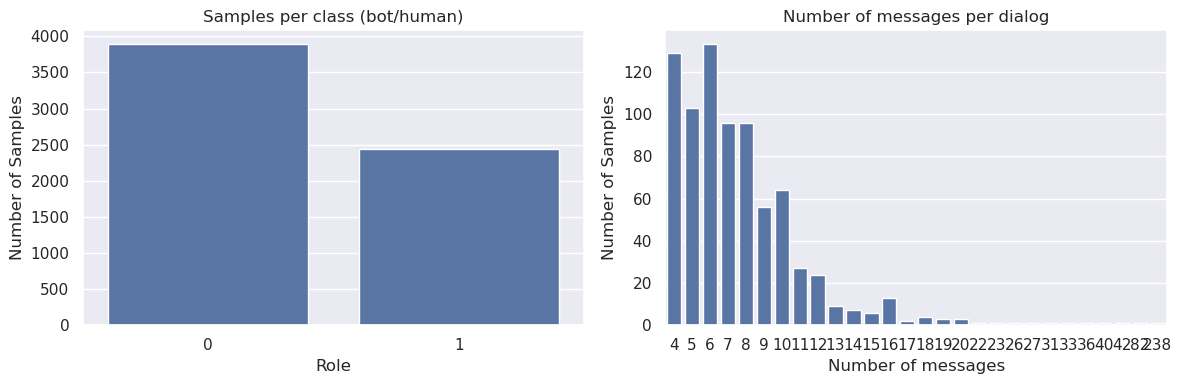

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=list(bots_cnt.keys()), y=list(bots_cnt.values()), ax=axes[0])
axes[0].set_title("Samples per class (bot/human)")
axes[0].set_xlabel("Role")
axes[0].set_ylabel("Number of Samples")
axes[0].tick_params(
    axis="x",
)

sns.barplot(
    x=list(messages_per_dialog.keys()), y=list(messages_per_dialog.values()), ax=axes[1]
)
axes[1].set_title("Number of messages per dialog")
axes[1].set_xlabel("Number of messages")
axes[1].set_ylabel("Number of Samples")
axes[1].tick_params(axis="x")

plt.tight_layout()
plt.show()

## Extracting features

Loading models that would be used to calculate perplexities

In [17]:
model_p = AutoModelForCausalLM.from_pretrained(
    "gpt2",
    trust_remote_code=True,
    output_hidden_states=True,
)
tokenizer = AutoTokenizer.from_pretrained(
    "gpt2",
    trust_remote_code=True,
)

/home/frznfrg/mambaforge/envs/DLS/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [18]:
def calculate_perplexity(
    message: str,
    context: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    device: str,
) -> float:
    """Calculates perplexity tokens in message based on this message and its context.

    Args:
        message (str): message for calculating perplexities
        context (str): context of a message. Perplexities are not calculated for tokens of context!
        model (AutoModelForCausalLM): model for calculating perplexities
        tokenizer (AutoTokenizer): model's tokenizer
        device (str): whether to run or "cuda" or "cpu"

    Returns:
        float: perplexity of a message
    """

    if context != "":
        context += " "
    full_input = context + message
    encodings = tokenizer(
        full_input, return_tensors="pt", truncation=True, max_length=512
    )
    input_ids = encodings["input_ids"].to(device)

    context_ids = tokenizer(
        context, return_tensors="pt", truncation=True, max_length=512
    )["input_ids"]
    context_length = context_ids.shape[1]

    labels = input_ids.clone()
    labels[:, :context_length] = -100

    model = model.to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss.item()

    perplexity = math.exp(loss)
    return perplexity

In [19]:
def run_perplexities(dataset: datasets.Dataset) -> List[float]:
    """Calculates perplexities for each message in a dialog

    Args:
        dataset (datasets.Dataset): dataset with dialogs

    Returns:
        List[float]: list of perplexities for each message in a dialog
    """
    perplexities = []
    for sample in tqdm(dataset):
        context = ""
        sample_perplexities = []
        for i, message in enumerate(sample["text"]):
            ppl = calculate_perplexity(message, context, model_p, tokenizer, device)
            sample_perplexities.append(ppl)
            context += " " + message
            context = context.strip()
        perplexities.append(sample_perplexities)
    return perplexities

In [20]:
train_perplexities = run_perplexities(dataset["train"])

  0%|          | 0/786 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


In [21]:
ppl_train_df = dataset["train"].to_pandas()
ppl_train_df["perplexities"] = train_perplexities
ppl_train_df.head()

,id,text,is_bot,participant_index,perplexities
0,000c0bd4f6554034ae2a050b5d8f6dea,"[че как?, Жопка, жопа жопа/, жопич, жопич жопич]","[1, 0, 1, 0, 1]","[0, 1, 0, 1, 0]","[36.426729067469466, 32.93950756777866, 25.016..."
1,009952d565384a69b5ddf1ec76608391,"[чио рио?, ""Чио Рио"" – это, вероятно, отсылка ...","[0, 1, 0, 1]","[0, 1, 0, 1]","[92.98256962075439, 11.332784454682079, 4.4705..."
2,00a66ccfbb7f42f39da2b641072d5ef6,"[I am OpenAI Assistant!, О, круто. Я Артем. А ...","[0, 1, 0, 1, 0, 1]","[0, 1, 0, 1, 0, 1]","[3171.243806892624, 16.006421545684013, 19.096..."
3,00ee738403dc4b4f98300d110ad7e8ef,"[hi, aboba, привет! как тебя зовут?, aboba, не...","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 1, 0, 1, 0, 1]","[nan, 69512.87016613214, 12.643755994195148, 1..."
4,011c5d7ad652481d90d502372d230232,"[Hello, Hey there! How's it going? 😊, I'm doin...","[0, 1, 0, 1, 0, 1, 0, 1]","[0, 1, 0, 1, 0, 1, 0, 1]","[nan, 24.13882257785323, 11.67491498872683, 22..."


In [22]:
def get_features(df: pd.DataFrame, stage="train") -> dict:
    """Extracts features (min perplexity, mean perplexity, perplexity variance,
    number of messages, text of messages) for each user in a dialog from a dataframe.

    Args:
        df (pd.DataFrame): dataframe with dialogs
        stage (str, optional): train or val. If set to train then the label column is provided. Defaults to "train".

    Returns:
        dict: columns with extracted features
    """
    if stage == "train":
        data_with_ppl = {
            "ID": [],
            "is_bot": [],
            "mean_ppl": [],
            "min_ppl": [],
            "variance_ppl": [],
            "num_messages": [],
            "text": [],
        }
    else:
        data_with_ppl = {
            "ID": [],
            "mean_ppl": [],
            "min_ppl": [],
            "variance_ppl": [],
            "num_messages": [],
            "text": [],
        }

    for _, row in df.iterrows():
        if stage == "train":
            is_user_bot = dict(zip(row["participant_index"], row["is_bot"]))

        ppl_per_user = {0: [], 1: []}
        text_per_user = {0: [], 1: []}
        for participant, perplexity, text in zip(
            row["participant_index"], row["perplexities"], row["text"]
        ):
            if not np.isnan(perplexity):
                ppl_per_user[int(participant)].append(perplexity)
            text_per_user[int(participant)].append(text)

        for participant in ppl_per_user.keys():
            if ppl_per_user[participant] != []:
                min_ppl = np.min(ppl_per_user[participant])
                mean_ppl = np.mean(ppl_per_user[participant])
                variance_ppl = np.var(ppl_per_user[participant])
            else:
                min_ppl = np.nan
                mean_ppl = np.nan
                variance_ppl = np.nan
            num_messages = len(text_per_user[participant])
            text = " ".join(text_per_user[participant])

            new_id = row["id"] + "_" + str(participant)
            data_with_ppl["ID"].append(new_id)
            data_with_ppl["mean_ppl"].append(mean_ppl)
            data_with_ppl["min_ppl"].append(min_ppl)
            data_with_ppl["variance_ppl"].append(variance_ppl)
            data_with_ppl["num_messages"].append(num_messages)
            data_with_ppl["text"].append(text)
            if stage == "train":
                data_with_ppl["is_bot"].append(is_user_bot[str(participant)])
    return data_with_ppl

In [23]:
ppl_train_df = pd.DataFrame.from_dict(get_features(ppl_train_df))
ppl_train_df = ppl_train_df.dropna()
ppl_train_df.head()

,ID,is_bot,mean_ppl,min_ppl,variance_ppl,num_messages,text
0,000c0bd4f6554034ae2a050b5d8f6dea_0,1,21.162650,2.044798,2.044453e+02,3,че как? жопа жопа/ жопич жопич
1,000c0bd4f6554034ae2a050b5d8f6dea_1,0,20.776682,8.613856,1.479343e+02,2,Жопка жопич
2,009952d565384a69b5ddf1ec76608391_0,0,48.726543,4.470516,1.958596e+03,2,"чио рио? да это отсылка, но почему именно на это"
3,009952d565384a69b5ddf1ec76608391_1,1,8.782652,6.232519,6.503177e+00,2,"""Чио Рио"" – это, вероятно, отсылка к популярно..."
4,00a66ccfbb7f42f39da2b641072d5ef6_0,0,1067.864297,13.252675,2.212108e+06,3,I am OpenAI Assistant! опенэйаю ну то и имею


### Visualizing extracted perplexity distributions

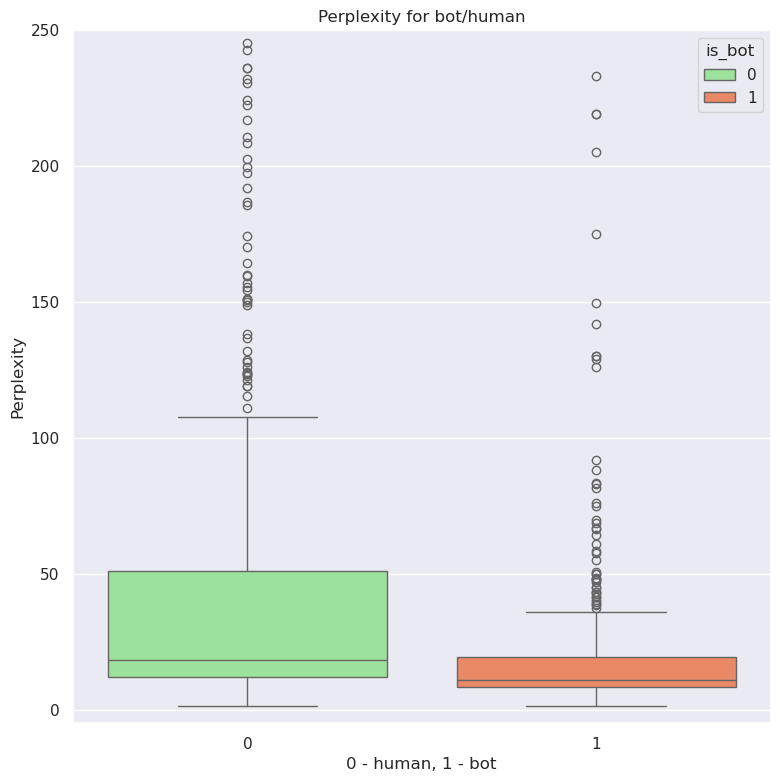

In [24]:
plt.figure(figsize=(9, 9))
palette = {}
sns.boxplot(
    x="is_bot",
    y="mean_ppl",
    data=ppl_train_df,
    hue="is_bot",
    palette=["lightgreen", "coral"],
)
plt.title("Perplexity for bot/human")
plt.xlabel("0 - human, 1 - bot")
plt.ylabel("Perplexity")
plt.ylim(-5, 250)
plt.tick_params(axis="x")
plt.show()

## Trying to classify based on perplexities only

In [25]:
perplexities = ppl_train_df["mean_ppl"].values
labels = ppl_train_df["is_bot"].values

thresholds = np.sort(perplexities)

best_threshold = None
best_f1 = 0

for threshold in thresholds:
    preds = (perplexities < threshold).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best threshold: {best_threshold}, Train F1: {best_f1:.3f}")

Best threshold: 12.826578577923152, Train F1: 0.583


In [26]:
preds = (perplexities < best_threshold).astype(int)
accuracy_score(labels, preds)

0.6811224489795918

## Extracting features from test split

In [27]:
test_perplexities = run_perplexities(dataset["test"])

  0%|          | 0/338 [00:00<?, ?it/s]

In [28]:
ppl_test_df = dataset["test"].to_pandas()
ppl_test_df["perplexities"] = test_perplexities
ppl_test_df.head()

,id,text,participant_index,perplexities
0,00559a1338f444c18eb301f1c822b483,"[квадрокоптth, Привет, что это?, экто квадратн...","[0, 1, 0, 1, 0]","[111.36683696304041, 7.28776558396616, 8.15562..."
1,007bf899fb5b4a3b8105183d0ca56cfa,"[hello, привет как дела гыы, а у тебя как?, от...","[0, 1, 0, 1]","[nan, 13.11185582467071, 13.209631294392736, 2..."
2,00ae575033054ce3ba68d2d3e1ba30e2,"[йоуйоу как оно, Как дела?, норм а у тебя, нян...","[0, 1, 0, 1, 0, 1, 0, 1, 0]","[34.07587737138938, 20.58313881749836, 21.4354..."
3,01763d48ee644bbb99bffb1a63c18bb4,"[ХОЛОКОСТ?, сори я не в курсе такого, СКОЛЬКО ...","[0, 1, 0, 1, 0, 1]","[11.953920654612551, 10.224271885257176, 18.48..."
4,02f44e0ff9ab47a1ae060e9d7ac10cd7,"[Привет!, чё как?, никак ))))00)), да, бывает ...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]","[30.968580134033434, 17.372830366565605, 507.3..."


In [29]:
ppl_test_df = pd.DataFrame.from_dict(get_features(ppl_test_df, stage="val"))
ppl_test_df["mean_ppl"] = ppl_test_df["mean_ppl"].fillna(0)
ppl_test_df.head()

,ID,mean_ppl,min_ppl,variance_ppl,num_messages,text
0,00559a1338f444c18eb301f1c822b483_0,42.042484,6.604987,2403.333671,3,квадрокоптth экто квадратный вертолёт харош
1,00559a1338f444c18eb301f1c822b483_1,8.317823,7.287766,1.061018,2,"Привет, что это? Понял, я знаю только квадроберов"
2,007bf899fb5b4a3b8105183d0ca56cfa_0,13.209631,13.209631,0.000000,2,hello а у тебя как?
3,007bf899fb5b4a3b8105183d0ca56cfa_1,18.211183,13.111856,26.003136,2,привет как дела гыы отлично тащусь\n гыы
4,00ae575033054ce3ba68d2d3e1ba30e2_0,31.003214,8.118344,638.251238,5,йоуйоу как оно норм а у тебя чеееееееееее я ве...


### Saving a baseline submission

In [30]:
submission = ppl_test_df
submission["is_bot"] = (submission["mean_ppl"] < best_threshold).astype(float)
submission = submission.drop(
    columns=["mean_ppl", "min_ppl", "variance_ppl", "num_messages", "text"]
)
submission.head()

,ID,is_bot
0,00559a1338f444c18eb301f1c822b483_0,0.0
1,00559a1338f444c18eb301f1c822b483_1,1.0
2,007bf899fb5b4a3b8105183d0ca56cfa_0,0.0
3,007bf899fb5b4a3b8105183d0ca56cfa_1,0.0
4,00ae575033054ce3ba68d2d3e1ba30e2_0,0.0


# Conducting experiments on features and classifiers

## Experiment 1. Ridge regression on perplexities

In [31]:
ppl_train_df.head()

,ID,is_bot,mean_ppl,min_ppl,variance_ppl,num_messages,text
0,000c0bd4f6554034ae2a050b5d8f6dea_0,1,21.162650,2.044798,2.044453e+02,3,че как? жопа жопа/ жопич жопич
1,000c0bd4f6554034ae2a050b5d8f6dea_1,0,20.776682,8.613856,1.479343e+02,2,Жопка жопич
2,009952d565384a69b5ddf1ec76608391_0,0,48.726543,4.470516,1.958596e+03,2,"чио рио? да это отсылка, но почему именно на это"
3,009952d565384a69b5ddf1ec76608391_1,1,8.782652,6.232519,6.503177e+00,2,"""Чио Рио"" – это, вероятно, отсылка к популярно..."
4,00a66ccfbb7f42f39da2b641072d5ef6_0,0,1067.864297,13.252675,2.212108e+06,3,I am OpenAI Assistant! опенэйаю ну то и имею


In [32]:
x = ppl_train_df["mean_ppl"].clip(upper=110).values.reshape(-1, 1)
scaler = RobustScaler()
x = scaler.fit_transform(x)
y = ppl_train_df["is_bot"].values

In [33]:
x_test = ppl_test_df["mean_ppl"].clip(upper=110).values.reshape(-1, 1)
x_test = scaler.fit_transform(x_test)

In [34]:
ridge_logreg = LogisticRegression(penalty="l2", class_weight="balanced")
scores = cross_validate(
    ridge_logreg,
    x,
    y,
    cv=3,
    scoring=("accuracy", "roc_auc", "f1", "neg_log_loss"),
    return_train_score=True,
)
pd.DataFrame.from_dict(scores)

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_f1,train_f1,test_neg_log_loss,train_neg_log_loss
0,0.005682,0.007751,0.543021,0.498565,0.690557,0.691333,0.544762,0.536283,-0.655757,-0.666753
1,0.002688,0.006005,0.483748,0.521531,0.712843,0.681079,0.534483,0.545455,-0.671530,-0.664060
2,0.002779,0.006880,0.501916,0.510516,0.671425,0.700847,0.535714,0.540395,-0.668325,-0.663965


## Experiment 2. Random forest on perplexities

In [35]:
forest_clf = RandomForestClassifier(class_weight="balanced", max_depth=3)
scores = cross_validate(
    forest_clf,
    x,
    y,
    cv=3,
    scoring=("accuracy", "roc_auc", "f1", "neg_log_loss"),
    return_train_score=True,
)
pd.DataFrame.from_dict(scores)

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_f1,train_f1,test_neg_log_loss,train_neg_log_loss
0,0.173018,0.021707,0.717017,0.690909,0.683463,0.749736,0.581921,0.585366,-0.606723,-0.601150
1,0.145435,0.019063,0.688337,0.700478,0.683895,0.751821,0.595533,0.575305,-0.649944,-0.594886
2,0.134454,0.018338,0.687739,0.707457,0.675188,0.760184,0.560647,0.585366,-0.635336,-0.594829


In [36]:
forest_clf.fit(x, y)
probas = forest_clf.predict_proba(x_test)

In [37]:
submission = ppl_test_df
submission["is_bot"] = probas[:, 1]
submission = submission.drop(columns=["mean_ppl", "text"])
submission.head()

,ID,min_ppl,variance_ppl,num_messages,is_bot
0,00559a1338f444c18eb301f1c822b483_0,6.604987,2403.333671,3,0.381795
1,00559a1338f444c18eb301f1c822b483_1,7.287766,1.061018,2,0.703584
2,007bf899fb5b4a3b8105183d0ca56cfa_0,13.209631,0.000000,2,0.300682
3,007bf899fb5b4a3b8105183d0ca56cfa_1,13.111856,26.003136,2,0.312196
4,00ae575033054ce3ba68d2d3e1ba30e2_0,8.118344,638.251238,5,0.361455


## Experiment 3. Extracting message embeddings and training random forest both on perplexities and embeddings

In [38]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [39]:
train_texts = ppl_train_df["text"].values
train_embeddings = model.encode(train_texts)

In [40]:
train_ppls = ppl_train_df["mean_ppl"].values.reshape(-1, 1)
x = np.hstack([train_ppls, train_embeddings])
x.shape

(1568, 385)

Reducing embeddins size from 384 to 50 using PCA decomposition significantly improved performance

In [41]:
def print_metrics(scores: dict):
    print("Train scores:")
    print(f"Accuracy: {np.mean(scores['train_accuracy']):.4f}")
    print(f"ROC AUC: {np.mean(scores['train_roc_auc']):.4f}")
    print(f"F1: {np.mean(scores['train_f1']):.4f}")
    print(f"Log Loss: {-np.mean(scores['train_neg_log_loss']):.4f}")

    print("\nValidation scores:")
    print(f"Accuracy: {np.mean(scores['test_accuracy']):.4f}")
    print(f"ROC AUC: {np.mean(scores['test_roc_auc']):.4f}")
    print(f"F1: {np.mean(scores['test_f1']):.4f}")
    print(f"Log Loss: {-np.mean(scores['test_neg_log_loss']):.4f}")

In [42]:
perplexities = ppl_train_df["mean_ppl"].values.reshape(-1, 1)
X = np.hstack([perplexities, train_embeddings])
y = ppl_train_df["is_bot"].values


pipeline = Pipeline(
    [
        ("pca", PCA(n_components=50)),
        ("classifier", RandomForestClassifier(class_weight="balanced", max_depth=10)),
    ]
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    pipeline,
    X,
    y,
    cv=cv,
    scoring=("accuracy", "roc_auc", "f1", "neg_log_loss"),
    return_train_score=True,
)

print_metrics(scores)

Train scores:
Accuracy: 0.9919
ROC AUC: 0.9996
F1: 0.9882
Log Loss: 0.2420

Validation scores:
Accuracy: 0.7519
ROC AUC: 0.7943
F1: 0.5520
Log Loss: 0.5284


In [43]:
test_ppls = ppl_test_df["mean_ppl"].values.reshape(-1, 1)
test_texts = ppl_test_df["text"].values
test_embeddings = model.encode(test_texts)

In [44]:
x_test = np.hstack([test_ppls, test_embeddings])
pipeline.fit(X, y)
probas = pipeline.predict_proba(x_test)

In [45]:
submission = ppl_test_df
submission["is_bot"] = probas[:, 1]
submission = submission.drop(columns=["mean_ppl", "text"])
submission.head()

,ID,min_ppl,variance_ppl,num_messages,is_bot
0,00559a1338f444c18eb301f1c822b483_0,6.604987,2403.333671,3,0.148317
1,00559a1338f444c18eb301f1c822b483_1,7.287766,1.061018,2,0.494116
2,007bf899fb5b4a3b8105183d0ca56cfa_0,13.209631,0.000000,2,0.305636
3,007bf899fb5b4a3b8105183d0ca56cfa_1,13.111856,26.003136,2,0.113025
4,00ae575033054ce3ba68d2d3e1ba30e2_0,8.118344,638.251238,5,0.438642


## Experiment 4. Using bossting instead of random forest

In [46]:
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=3,
    loss_function="Logloss",
    eval_metric="Logloss",
    random_seed=42,
    verbose=100,
    class_weights=[2, 3],
    early_stopping_rounds=100,
    task_type="GPU",
)

In [47]:
perplexities = ppl_train_df["mean_ppl"].values.reshape(-1, 1)
X = np.hstack([perplexities, train_embeddings])
y = ppl_train_df["is_bot"].values


pipeline = Pipeline(
    [
        ("pca", PCA(n_components=50)),
        ("classifier", cat_model),
    ]
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    pipeline,
    X,
    y,
    cv=cv,
    scoring=("accuracy", "roc_auc", "f1", "neg_log_loss"),
    return_train_score=True,
)


print_metrics(scores)

0:	learn: 0.6852262	total: 50.1ms	remaining: 15s
100:	learn: 0.4773886	total: 290ms	remaining: 571ms
200:	learn: 0.4007415	total: 511ms	remaining: 252ms
299:	learn: 0.3454197	total: 715ms	remaining: 0us


0:	learn: 0.6829000	total: 4.95ms	remaining: 1.48s
100:	learn: 0.4781197	total: 232ms	remaining: 458ms
200:	learn: 0.4054587	total: 451ms	remaining: 222ms
299:	learn: 0.3492410	total: 659ms	remaining: 0us


0:	learn: 0.6833631	total: 4.3ms	remaining: 1.28s
100:	learn: 0.4813077	total: 261ms	remaining: 514ms
200:	learn: 0.4050438	total: 502ms	remaining: 247ms
299:	learn: 0.3485928	total: 728ms	remaining: 0us


0:	learn: 0.6833999	total: 4.75ms	remaining: 1.42s
100:	learn: 0.4828039	total: 234ms	remaining: 461ms
200:	learn: 0.4105989	total: 449ms	remaining: 221ms
299:	learn: 0.3554629	total: 652ms	remaining: 0us


0:	learn: 0.6831213	total: 3.58ms	remaining: 1.07s
100:	learn: 0.4832888	total: 231ms	remaining: 455ms
200:	learn: 0.4107928	total: 449ms	remaining: 221ms
299:	learn: 0.3562640	total: 659ms	remaining: 0us
Train scores:
Accuracy: 0.9013
ROC AUC: 0.9642
F1: 0.8538
Log Loss: 0.3445

Validation scores:
Accuracy: 0.7602
ROC AUC: 0.8008
F1: 0.6366
Log Loss: 0.5139


In [48]:
pipeline.fit(X, y)

0:	learn: 0.6835206	total: 3.89ms	remaining: 1.16s
100:	learn: 0.4932944	total: 256ms	remaining: 505ms
200:	learn: 0.4255354	total: 481ms	remaining: 237ms
299:	learn: 0.3736149	total: 700ms	remaining: 0us


Pipeline(steps=[('pca', PCA(n_components=50)),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7f528421b850>)])

In [49]:
probas = pipeline.predict_proba(x_test)

In [50]:
submission = ppl_test_df
submission["is_bot"] = probas[:, 1]
submission = submission.drop(
    columns=["mean_ppl", "text", "min_ppl", "variance_ppl", "num_messages"]
)
submission.head()

,ID,is_bot
0,00559a1338f444c18eb301f1c822b483_0,0.109732
1,00559a1338f444c18eb301f1c822b483_1,0.606291
2,007bf899fb5b4a3b8105183d0ca56cfa_0,0.259852
3,007bf899fb5b4a3b8105183d0ca56cfa_1,0.100823
4,00ae575033054ce3ba68d2d3e1ba30e2_0,0.503313


In [51]:
submission.to_csv("../data/submission.csv", index=False)

## Experiment 5. Extracting additional features: min perplexity, perplexity variance and number of messages

In [52]:
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=5,
    loss_function="Logloss",
    eval_metric="Logloss",
    random_seed=42,
    verbose=100,
    class_weights=[2, 3],
    early_stopping_rounds=100,
    task_type="GPU",
)

In [53]:
mean_ppl = ppl_train_df["mean_ppl"].values.reshape(-1, 1)
min_ppl = ppl_train_df["min_ppl"].values.reshape(-1, 1)
variance_ppl = ppl_train_df["variance_ppl"].values.reshape(-1, 1)
num_messages = ppl_train_df["num_messages"].values.reshape(-1, 1)

X = np.hstack([mean_ppl, min_ppl, variance_ppl, num_messages, train_embeddings])
y = ppl_train_df["is_bot"].values


pipeline = Pipeline(
    [
        ("pca", PCA(n_components=100)),
        ("classifier", cat_model),
    ]
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    pipeline,
    X,
    y,
    cv=cv,
    scoring=("accuracy", "roc_auc", "f1", "neg_log_loss"),
    return_train_score=True,
)


print_metrics(scores)

0:	learn: 0.6796903	total: 6.14ms	remaining: 1.83s
100:	learn: 0.3476071	total: 396ms	remaining: 779ms
200:	learn: 0.2256444	total: 721ms	remaining: 355ms
299:	learn: 0.1494706	total: 1.02s	remaining: 0us


0:	learn: 0.6814892	total: 3.66ms	remaining: 1.09s
100:	learn: 0.3526492	total: 268ms	remaining: 528ms
200:	learn: 0.2256982	total: 529ms	remaining: 261ms
299:	learn: 0.1518680	total: 784ms	remaining: 0us


0:	learn: 0.6812494	total: 4.72ms	remaining: 1.41s
100:	learn: 0.3554224	total: 276ms	remaining: 544ms
200:	learn: 0.2310144	total: 532ms	remaining: 262ms
299:	learn: 0.1549723	total: 789ms	remaining: 0us


0:	learn: 0.6813129	total: 3.86ms	remaining: 1.15s
100:	learn: 0.3409161	total: 269ms	remaining: 529ms
200:	learn: 0.2227792	total: 530ms	remaining: 261ms
299:	learn: 0.1520956	total: 788ms	remaining: 0us


0:	learn: 0.6813329	total: 3.36ms	remaining: 1s
100:	learn: 0.3568641	total: 270ms	remaining: 531ms
200:	learn: 0.2321822	total: 533ms	remaining: 262ms
299:	learn: 0.1549492	total: 793ms	remaining: 0us
Train scores:
Accuracy: 0.9973
ROC AUC: 1.0000
F1: 0.9961
Log Loss: 0.1536

Validation scores:
Accuracy: 0.7762
ROC AUC: 0.8177
F1: 0.6408
Log Loss: 0.4876


In [54]:
ppl_test_df = ppl_test_df.fillna(0)

In [55]:
test_mean_ppl = ppl_test_df["mean_ppl"].values.reshape(-1, 1)
test_min_ppl = ppl_test_df["min_ppl"].values.reshape(-1, 1)
test_variance_ppl = ppl_test_df["variance_ppl"].values.reshape(-1, 1)
test_num_messages = ppl_test_df["num_messages"].values.reshape(-1, 1)

x_test = np.hstack(
    [test_mean_ppl, test_min_ppl, test_variance_ppl, test_num_messages, test_embeddings]
)

In [56]:
pipeline.fit(X, y)
probas = pipeline.predict_proba(x_test)

0:	learn: 0.6800235	total: 3.19ms	remaining: 954ms
100:	learn: 0.3803338	total: 278ms	remaining: 547ms
200:	learn: 0.2652259	total: 539ms	remaining: 266ms
299:	learn: 0.1883073	total: 802ms	remaining: 0us


In [57]:
submission = ppl_test_df
submission["is_bot"] = probas[:, 1]
submission = submission.drop(
    columns=["mean_ppl", "text", "min_ppl", "variance_ppl", "num_messages"]
)
submission.head()

,ID,is_bot
0,00559a1338f444c18eb301f1c822b483_0,0.057868
1,00559a1338f444c18eb301f1c822b483_1,0.548630
2,007bf899fb5b4a3b8105183d0ca56cfa_0,0.093853
3,007bf899fb5b4a3b8105183d0ca56cfa_1,0.044831
4,00ae575033054ce3ba68d2d3e1ba30e2_0,0.350024


Loading the best result

In [58]:
submission.to_csv("../data/submission.csv", index=False)